In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Employees Table dengan variasi usia & gaji lebih kompleks
employees = spark.createDataFrame([
    ('Tono', 25, 'M', 3000, 1),
    ('Ana', 25, 'F', 3200, 2),
    ('Budi', 26, 'M', 2800, 1),
    ('Citra', 26, 'F', 4500, 1),
    ('Dewi', 27, 'F', 4000, 2),
    ('Eko', 27, 'M', 4200, 2),
    ('Farah', 27, 'F', 3800, 1),
    ('Gilang', 28, 'M', 5000, 2),
    ('Hana', 28, 'F', 4700, 1),
    ('Iwan', 29, 'M', 5300, 2),
    ('Joko', 30, 'M', 3600, 1),
    ('Kiki', 30, 'F', 5100, 2),
    ('Lina', 31, 'F', 4800, 1)
], ['Name','Age','Gender','Salary','DeptID'])

# Departments Table
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptID','DeptName'])

# Projects Table
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptID','ProjectName'])

# Create temp views
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptID = d.DeptID
JOIN projects p ON e.DeptID = p.DeptID
''').show()

[Stage 9:===========================================================(2 + 0) / 2]

+------+---+---------+-----------+
|  Name|Age| DeptName|ProjectName|
+------+---+---------+-----------+
|  Lina| 31|       HR|  Project A|
|  Joko| 30|       HR|  Project A|
|  Hana| 28|       HR|  Project A|
| Farah| 27|       HR|  Project A|
| Citra| 26|       HR|  Project A|
|  Budi| 26|       HR|  Project A|
|  Tono| 25|       HR|  Project A|
|  Kiki| 30|Marketing|  Project B|
|  Iwan| 29|Marketing|  Project B|
|Gilang| 28|Marketing|  Project B|
|   Eko| 27|Marketing|  Project B|
|  Dewi| 27|Marketing|  Project B|
|   Ana| 25|Marketing|  Project B|
+------+---+---------+-----------+



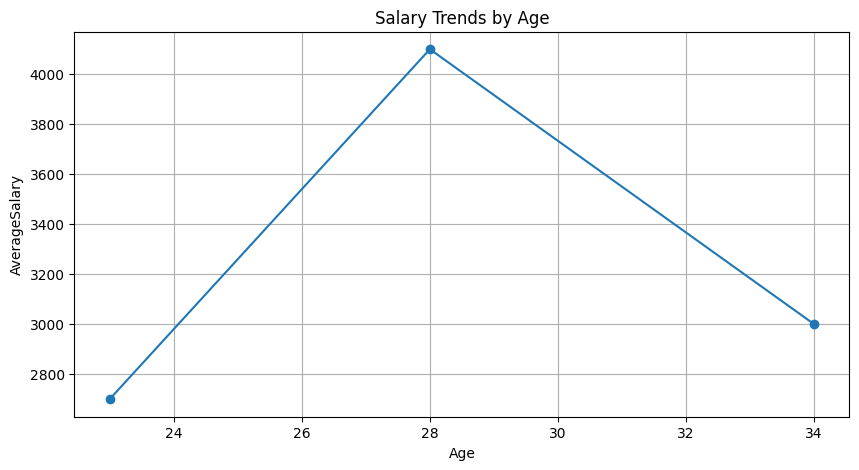

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to pandas
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization
plt.figure(figsize=(10,5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('AverageSalary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()

In [5]:
# Rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji.
spark.sql('''
SELECT e.Name, e.DeptID, e.Salary, AVG(e.Salary) OVER (PARTITION BY e.DeptID) AS RataRataGajiDept,
RANK() OVER (PARTITION BY e.DeptID ORDER BY e.Salary DESC) AS RankGaji
FROM employees e
''').show()

+----+------+------+----------------+--------+
|Name|DeptID|Salary|RataRataGajiDept|RankGaji|
+----+------+------+----------------+--------+
|Tono|     1|  3000|          2850.0|       1|
|Budi|     1|  2700|          2850.0|       2|
| Ana|     2|  4100|          4100.0|       1|
+----+------+------+----------------+--------+



In [6]:
spark.sql('''
SELECT e.Name, e.DeptID, e.Age, e.Salary, AVG(e.Salary) OVER (PARTITION BY e.DeptID, e.Age) AS AvgSalaryPerAgeDept,
ROW_NUMBER() OVER (PARTITION BY e.DeptID ORDER BY e.Age) AS AgeTrendOrder
FROM employees e
ORDER BY e.DeptID, e.Age
''').show()

+----+------+---+------+-------------------+-------------+
|Name|DeptID|Age|Salary|AvgSalaryPerAgeDept|AgeTrendOrder|
+----+------+---+------+-------------------+-------------+
|Budi|     1| 23|  2700|             2700.0|            1|
|Tono|     1| 34|  3000|             3000.0|            2|
| Ana|     2| 28|  4100|             4100.0|            1|
+----+------+---+------+-------------------+-------------+



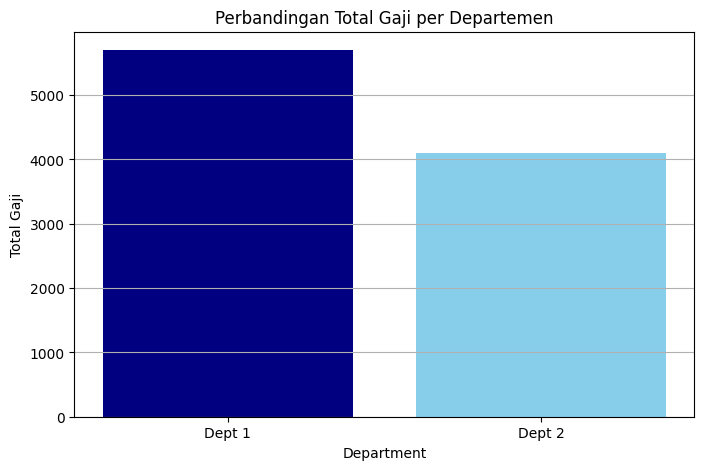

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Mengubah SQL ke Pandas
salary = spark.sql('''
SELECT DeptID, SUM(Salary) AS TotalSalary, COUNT(*) AS TotalEmployees
FROM employees
GROUP BY DeptID
ORDER BY DeptID
''').toPandas()

# Memberi warna ke grafik batang
colors = ['navy', 'skyblue']

# Visualisasi
plt.figure(figsize=(8,5))
plt.bar(salary['DeptID'], salary['TotalSalary'], color=colors)
plt.xticks([1, 2], ['Dept 1', 'Dept 2'])
plt.xlabel('Department')
plt.ylabel('Total Gaji')
plt.title('Perbandingan Total Gaji per Departemen')
plt.grid(axis='y')
plt.show()

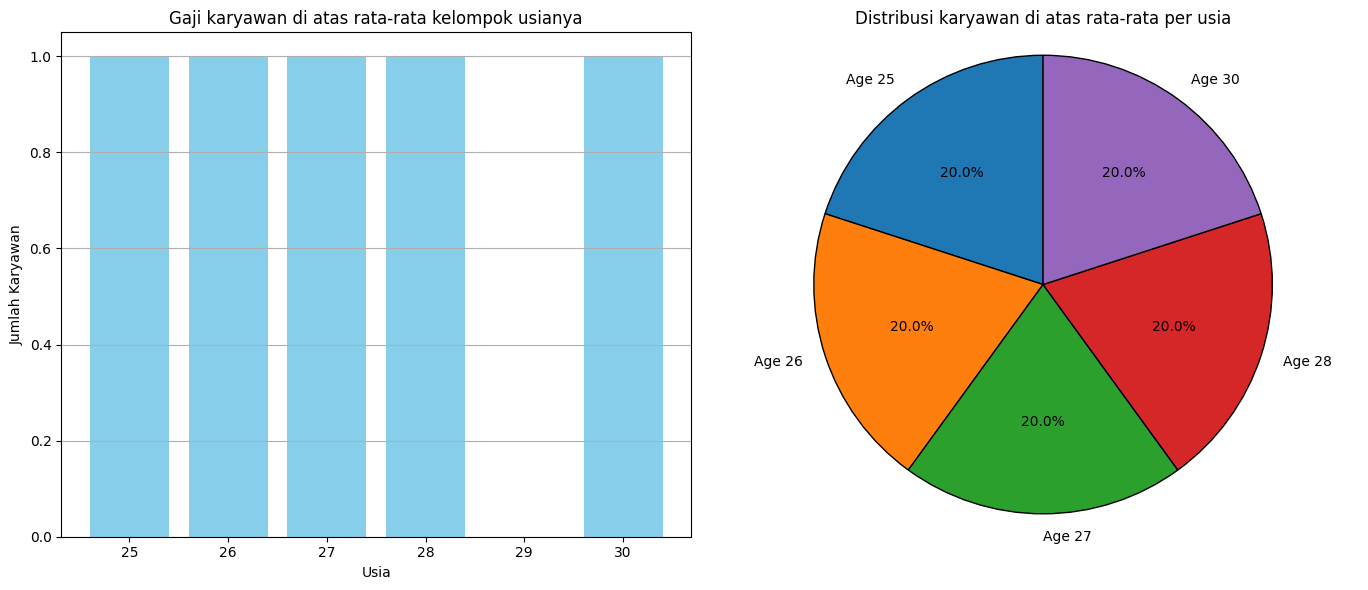

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Mengambil data karyawan dengan gaji di atas rata-rata per kelompok usia
rata_rata = spark.sql('''
SELECT e.Name, e.Age, e.Gender, e.Salary
FROM employees e
WHERE e.Salary > (SELECT AVG(e2.Salary)
FROM employees e2
WHERE e2.Age = e.Age)
ORDER BY e.Age
''').toPandas()

# Mengelompokkan berdasarkan usia
kelompok_usia = rata_rata.groupby('Age').size().reset_index(name='Count')

# Membuat figure dengan 2 subplot
fig, axs = plt.subplots(1, 2, figsize=(14,6))

# Bar Chart di subplot kiri
axs[0].bar(kelompok_usia['Age'], kelompok_usia['Count'], color='skyblue')
axs[0].set_xlabel('Usia')
axs[0].set_ylabel('Jumlah Karyawan')
axs[0].set_title('Gaji karyawan di atas rata-rata kelompok usianya')
axs[0].grid(axis='y')

# Pie Chart di subplot kanan
axs[1].pie(kelompok_usia['Count'], labels=[f'Age {a}' for a in kelompok_usia['Age']],
           autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
axs[1].set_title('Distribusi karyawan di atas rata-rata per usia')
axs[1].axis('equal')

plt.tight_layout()
plt.show()
